In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition
import matplotlib.cm as cm
import combat as cb
from scipy.spatial.distance import pdist

np.random.seed(314)

In [43]:
def check_batch_distribution(X, batch_anno, axis, title=""):
    
    pca = decomposition.PCA(n_components=2)
    pca.fit(X)
    X_trans = pca.transform(X)

    all_batch_reps = []
    
    labels = set(batch_anno)
    colors = cm.spectral(np.linspace(0, 1, len(labels)))
    
    for val, col in zip(labels, colors):
        Z = X_trans[np.ix_((batch_anno==val))]
        rep = np.mean(Z, axis=0)
        all_batch_reps.append(rep)
        
        axis.scatter(Z[:, 0], Z[:, 1], label=val, marker='o', c=col, edgecolor='none')
        axis.add_artist(plt.Circle(rep, 5, color=col))
        
    axis.set_title(title)
    axis.legend(numpoints=1)
    
    all_batch_reps = np.array(all_batch_reps)
    return np.sum(pdist(all_batch_reps))


found 5 batches
found 0 numerical covariates...
found 0 categorical variables:	
Standardizing Data across genes.
Fitting L/S model and finding priors
Finding parametric adjustments


Adjusting data
Batch center distance before correction: 126.040448793
Batch center distance after correction: 55.1345989776
Batch center ratio (should be > 1): 2.28604997824


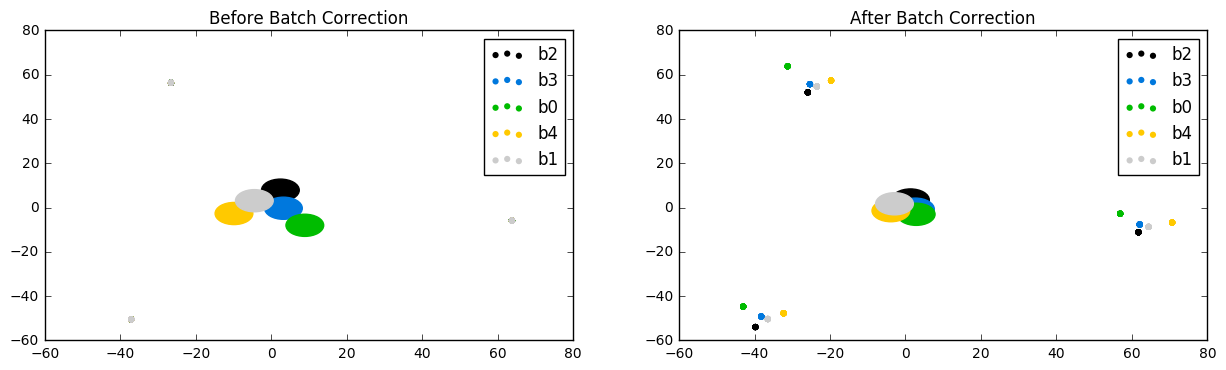

In [44]:
import enum 
import combat as cb

class Columns(str, enum.Enum):
    """Column types in FastGenomics CSV files"""
    CELLS = 'cellId*Ganzzahl'
    GENES = 'entrezId*Ganzzahl'
    EXPR = 'expressionValue*Zahl'
    BATCH = '_generated_batch*Text'
    # BATCH = 'batch'


# genes_path = fg_io.get_input_path('genes_data_input')
genes_path = "../sample_data/data/dataset/expressions_entrez.tsv"

# cells_meta = fg_io.get_input_path('cells_meta_input')
cells_meta = "../sample_data/data/dataset/cells.tsv"


# combat requires full matrix input - unstack input file
# combat expects matrix of shape [genes x cells], so index
# columns accordingly
data = (
    pd.read_csv(genes_path, sep='\t')
    #.dropna()
    .set_index([Columns.GENES, Columns.CELLS])
    #.loc[:, Columns.EXPR]
    .unstack()
    .fillna(0)
    )
pheno = pd.read_csv(cells_meta, sep="\t")

# data = pd.read_csv("../sample_data/data/dataset/bladder-expr.txt", sep="\t")
# pheno = pd.read_csv("../sample_data/data/dataset/bladder-pheno.txt", sep="\t")

corr = cb.combat(data, pheno[Columns.BATCH])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
total_batch_dist      = check_batch_distribution(data.values.T, pheno[Columns.BATCH], ax1, "Before Batch Correction")
total_batch_dist_corr = check_batch_distribution(corr.values.T, pheno[Columns.BATCH], ax2, "After Batch Correction")

print("Batch center distance before correction:", total_batch_dist)
print("Batch center distance after correction:", total_batch_dist_corr)
print("Batch center ratio (should be > 1):", total_batch_dist/total_batch_dist_corr)

plt.show()